## Import Modules

In [1]:
import os
import pickle
import numpy as np
import string
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/bnaturebengali-image-captioning-dataset'
WORKING_DIR = '/kaggle/working'

## Extract Image features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

2022-06-24 08:55:22.439198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 08:55:22.629178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 08:55:22.629944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 08:55:22.631236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Pictures')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8000 [00:00<?, ?it/s]

2022-06-24 08:55:29.059872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-24 08:55:30.100871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the captions data

In [7]:
with open(os.path.join(BASE_DIR, 'caption','caption.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
captions_doc

'1.jpg   দুই শিশু গ্রামে হাঁটছে।\n1.jpg   একটা নীল জামা পড়া শিশু।\n1.jpg   দুই শিশু খেলা করে।\n1.jpg   দুইটা শিশু দাঁড়িয়ে আছে।\n2.jpg   কিছু লোক নদী পার করছে।\n2.jpg   কিছু লোক বিল পার করছে।\n2.jpg   অনেকগুলো লোক নদী পার করছে।\n2.jpg   জমির ভিতর অনেকগুলো লোক।\n2.jpg   কিছু লোক নদী পার করছে।\n3.jpg   এক কৃষক ক্ষেতে কাজ করছে।\n3.jpg   এক কৃষক ধান ক্ষেতে কাজ করছে।\n3.jpg   রোদ এর নিচে একটা লোক দাঁড়িয়ে আছে।\n3.jpg   এক কৃষক ধান দেখছে।\n3.jpg   শার্ট পড়া একটা লোক।\n4.jpg   কিছু শিশু তাদের স্কুল থেকে বাড়িতে যায়।\n4.jpg   কিছু শিশু ও একটি ভবন।\n4.jpg   ভবনে কিছু শিশু খেলা করে।\n4.jpg   সবুজ ধান ক্ষেত।\n4.jpg   স্কুলের জামা পড়া কিছু শিশু।\n5.jpg   পাঁচটি নারী এক জায়গায় চলছে।\n5.jpg   পাঁচটি শিশু এক জায়গায় চলছে।\n5.jpg   পাঁচটি মেয়ে খেলছে।\n5.jpg   হাসিমুখে পাঁচটি মেয়ে।\n5.jpg   পাঁচটি মেয়ে খেলতেছে।\n6.jpg   কিছু লোক পাহাড়ে বসে আছে।\n6.jpg   কিছু লোক বসে আছে।\n6.jpg   রোদ এর নিছে কিছু লোক বসে আছে।\n6.jpg   পাহারের উপর কিছু লোক বসে আছে।\n6.jpg   হাসিমুখে কিছু লোক বসে আছে।\n7.jpg   নদীর পা

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/39106 [00:00<?, ?it/s]

In [10]:
len(mapping)

8000

In [11]:
mapping['6']

['  কিছু লোক পাহাড়ে বসে আছে।',
 '  কিছু লোক বসে আছে।',
 '  রোদ এর নিছে কিছু লোক বসে আছে।',
 '  পাহারের উপর কিছু লোক বসে আছে।',
 '  হাসিমুখে কিছু লোক বসে আছে।']

## Preprocessing the text data

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('।', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# before preprocess of text
mapping['7']

['  নদীর পানিতে কিছু মানুষ।',
 '  বস্তা নিয়ে কিছু গ্রামের মানুষ নদী পার হয়।',
 '  অনেকগুলো গ্রামের মানুষ পানিতে।',
 '  কিছু ছেলে ও মেয়ে নদী পার হয়।',
 '  কিছু গ্রামের মানুষ নদী পার হয়ে যায়।']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['7']

['startseq নদীর পানিতে কিছু মানুষ endseq',
 'startseq বস্তা নিয়ে কিছু গ্রামের মানুষ নদী পার হয় endseq',
 'startseq অনেকগুলো গ্রামের মানুষ পানিতে endseq',
 'startseq কিছু ছেলে মেয়ে নদী পার হয় endseq',
 'startseq কিছু গ্রামের মানুষ নদী পার হয়ে যায় endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

39104

In [18]:
all_captions[:10]

['startseq দুই শিশু গ্রামে হাঁটছে endseq',
 'startseq একটা নীল জামা পড়া শিশু endseq',
 'startseq দুই শিশু খেলা করে endseq',
 'startseq দুইটা শিশু দাঁড়িয়ে আছে endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq কিছু লোক বিল পার করছে endseq',
 'startseq অনেকগুলো লোক নদী পার করছে endseq',
 'startseq জমির ভিতর অনেকগুলো লোক endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq এক কৃষক ক্ষেতে কাজ করছে endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

9920

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

41

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

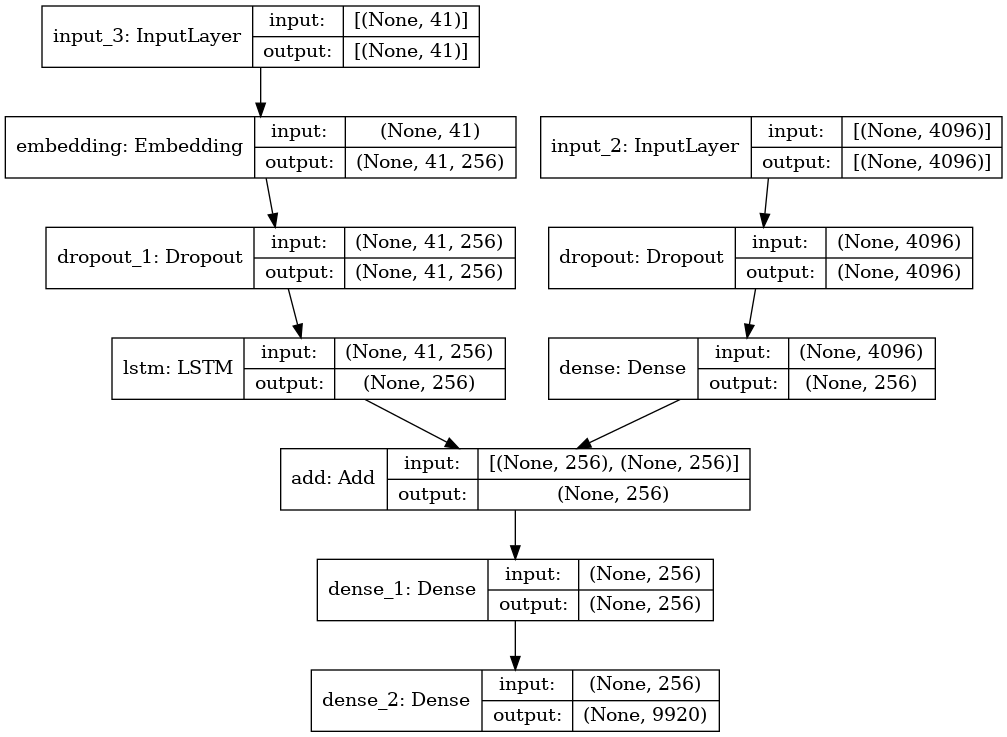

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 63s 279ms/step - loss: 1.7813


In [26]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Model Creation

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.422440
BLEU-2: 0.244285


## Results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "6000.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Pictures", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq একজন পুরুষ হেঁটে আসছে endseq
startseq গ্রামের পাকা রাস্তা দিয়ে হাতে দুধের বালতি নিয়ে হেটে আসছেন endseq
startseq একজন লোক যার পিছনে টি টং দোকান endseq
startseq বৃদ্ধলোকটি বালতি হাতে পথ দিয়ে যাচ্ছে endseq
startseq একজন গোয়ালা দুধ বিক্রি করতে যাচ্ছে endseq
startseq একজন বয়স্ক লোক পাকা রাস্তা ধরে এগিয়ে আসছে endseq
--------------------Predicted--------------------
startseq রাস্তা দিয়ে একজন পুরুষ হেটে আসছে দুপাশে রাস্তা দিয়ে একজন মহিলা হেটে আসছেন রাস্তার দুই পাশে গাছ এবং রাস্তা দিয়ে একজন রিকশা চালক হেটে আসছেন রাস্তার দুই পাশে গাছ দেখা যায় endseq


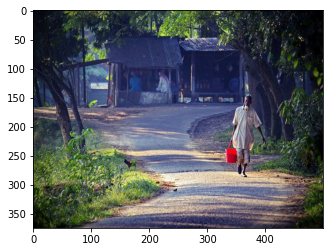

In [31]:
generate_caption("6001.jpg")

---------------------Actual---------------------
startseq কয়েকজন মানুষ পানির পাশ দিয়ে হেঁটে আসছে endseq
startseq একজন বিদেশি মহিলা কয়েকটা বাচ্চা নিয়ে হেটে আসছে endseq
startseq অনেকগুলো মানুষ আছে endseq
startseq একটা গলির রাস্তা দিয়ে কিছু মানুষ হেঁটে আসছে endseq
startseq একটি মহিলা কামেরা নিয়ে আছে তার পেছনে কিছু ছেলে আছে endseq
--------------------Predicted--------------------
startseq একটি ব্রিজে ৫জন ছেলে ছেলে বসে গল্প করছে endseq


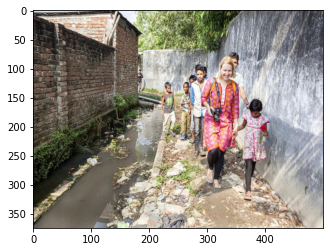

In [32]:
generate_caption("6020.jpg")

---------------------Actual---------------------
startseq হিজাব পরিহিত একজন নারী বোর্ডে লিখছে endseq
startseq একজন মেয়ে বোরকা হিজাব পরে একটি বোর্ড লিখছে endseq
startseq বোর্ডে মার্কার দিয়ে একটি মেয়ে বাংলা লিখে endseq
startseq মাথায় ওড়না দিয়ে একটি মেয়ে কিছু লিখছে হোয়াইট বোর্ডে endseq
startseq একজন শিক্ষার্থী হোয়াইট বোর্ডে মার্কার দিয়ে বাংলায় কিছু লিখছে endseq
--------------------Predicted--------------------
startseq একটি মেয়ে বস্তার উপর বসে আছে endseq


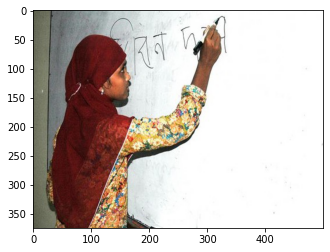

In [33]:
generate_caption("1003.jpg")

---------------------Actual---------------------
startseq পানির ওপাশে কয়েকজন নারী দাড়িয়ে আছে endseq
startseq একটি জায়গা বন্যার পানিতে ডুবে গেসে যার মাঝে কিছু মানুষ একটি দোকানের সামনে দাড়িয়ে এবং বসে আছে endseq
startseq একটি ঘরের সামনে কিছু বন্যা কবলিত মানুষ তাদের মধ্যে নারী শিশু আছে endseq
startseq দোকান ঘরের সামনে একজন নারী বসে আছে তার সামনে একজন নারী দাড়িয়ে তার পাশে দাড়িয়ে আছে জন শিশু endseq
startseq উঠানে পানির পাশে কয়েকজন মানুষ, একটি টিনের দোকান ঘর endseq
--------------------Predicted--------------------
startseq একটি টিনের বাড়ির সামনে একটি বাচ্চা ছেলে দাড়িয়ে আছে endseq


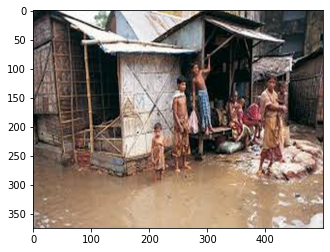

In [34]:
generate_caption("1015.jpg")

---------------------Actual---------------------
startseq একজন মানুষ মাইকে কথা বলছে endseq
startseq একজন লোক মাইকিং করছে endseq
startseq একজন মানুষ আছে endseq
startseq একটি মাইক আছে endseq
startseq একজন মানুষ বসে আছে endseq
--------------------Predicted--------------------
startseq একজন পুরুষ সাইকেল চালাচ্ছে endseq


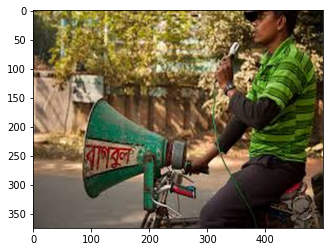

In [35]:
generate_caption("6050.jpg")

---------------------Actual---------------------
startseq একজন মানুষ কে ছাতা মাথায় দেখে একদল হাঁস পালানোর চেষ্টা করসে endseq
startseq ছাতা মাথায় এক বালক মাঠের মধ্যে একদল হাঁসের মাঝখানে দারিয়ে আছে endseq
startseq একটি বালক ছাতা মাথায় দিয়ে একদল পাখিকে তাড়িয়ে দিচ্ছে endseq
startseq নীল আকাশের নিচে একদল হাঁসকে তারিয়ে দিসসে একজন বালক endseq
startseq সবুজ মাঠে একদল হাসের মাঝে ছাতামাথায় দারিয়ে আছে একজন মানুষ endseq
--------------------Predicted--------------------
startseq কিছু হাসের চা তাড়িয়ে যাচ্ছে endseq


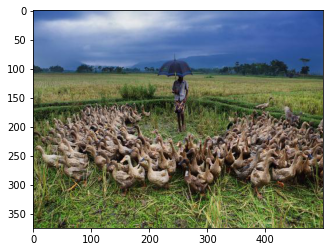

In [36]:
generate_caption("600.jpg")

---------------------Actual---------------------
startseq একজন পুরুষ দাড়িয়ে আছে endseq
startseq দুপাশে দেয়াল মাঝে একজন লোক দাড়িয়ে আছে endseq
startseq দুপাশে দুটি,দেয়াল আছে endseq
startseq লোকটি দাড়িয়ে আছে endseq
startseq সূর্যের আলোয় একটি লোকের ছায়া পড়ছে endseq
--------------------Predicted--------------------
startseq একটি ট্রেন রাস্তা দিয়ে একজন লোক হেটে যাচ্ছে endseq


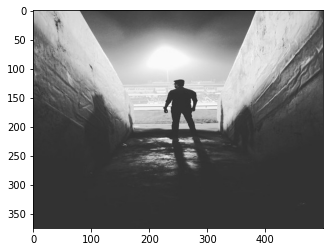

In [37]:
generate_caption("6005.jpg")

---------------------Actual---------------------
startseq দুইটি শিশু আছে endseq
startseq একজন বাচ্চা ছেলে একজন বাচ্চা মেয়ের ছবি তুলছেন endseq
startseq দুটি শিশু খেলছে endseq
startseq দুইজন বাচ্চা খেলা করছে endseq
startseq শিশু দুটি দিকে অপরের দিকে তাকিয়ে হাসছে endseq
--------------------Predicted--------------------
startseq একজন পুরুষ রাস্তা দিয়ে হেঁটে যাচ্ছে endseq


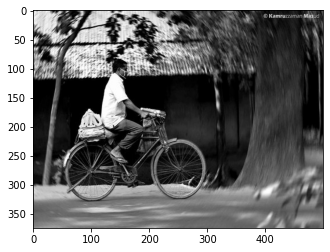

In [38]:
generate_caption("6025.jpg")

---------------------Actual---------------------
startseq তিনজন পুরুষ ব্যায়াম করছে endseq
startseq একটা পার্কের মধ্যে তিনজন লোক ব্যায়াম করছে এর কয়েকজন লোক গাছের নিচে বসে গল্প করছে endseq
startseq পিছনে কয়েকজন মানুষ বসে আছে endseq
startseq পিছনে অনেক গাছপালা আছে কিছু লোক ব্যায়াম করছে endseq
startseq পার্কে কিছু লোক বসে আছে তিনজন লোক ব্যায়াম করছে endseq
--------------------Predicted--------------------
startseq তিনজন ছেলে ব্যায়াম করছে endseq


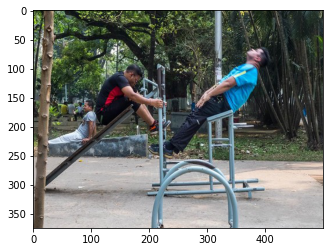

In [39]:
generate_caption("7025.jpg")

---------------------Actual---------------------
startseq কয়েকজন মানুষ আছে endseq
startseq কয়েকজন ছেলে মেয়ে পাহারের উপর উঠছে endseq
startseq কয়েকজন ভ্রমন পিপাসু মানুষ পাহাড়ে উঠছে endseq
startseq একজন পুরুষ পাহাড়ের গায়ে উঠে মটটলাঠি নিয়ে অন্যদের জন্য অপেক্ষা করছে endseq
startseq একজন যুবক পাহাড়ের গায়ে লাঠি নিয়ে দাড়িয়ে ধরেছে endseq
--------------------Predicted--------------------
startseq একজন পুরুষ মাথায় গামছা দিয়ে বৃষ্টির মাঝে হেটে আসছেন endseq


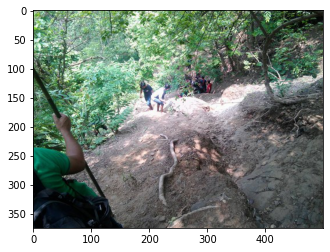

In [40]:
generate_caption("7225.jpg")

---------------------Actual---------------------
startseq তিনজন পুরুষ তাকিয়ে আছে endseq
startseq তিনজন ছেরে মোবাইল দিয়ে সেলফি তুলছে endseq
--------------------Predicted--------------------
startseq জন পুরুষ ঘাড়ে হাত রেখে দাড়িয়ে আছে যার একজনের হাতে ব্যাগ endseq


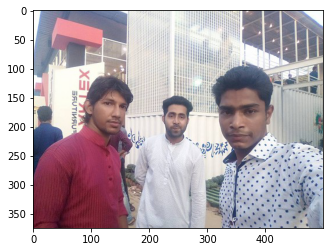

In [41]:
generate_caption("7825.jpg")

---------------------Actual---------------------
startseq একটি জলাশয় আছে endseq
startseq বড় একটা নদী দেখা যাচ্ছে endseq
startseq একটি নদী বয়ে চলেছে endseq
startseq নদীর পানি টলমল করছে endseq
startseq নদীর এক পাড় থেকে অন্য পাড়ে দৃশ্য দেখা যাচ্ছে endseq
--------------------Predicted--------------------
startseq একটি খাল থেকে একটি নৌকা খাল দিয়ে যাচ্ছেন একজন পুরুষ মানুষ endseq


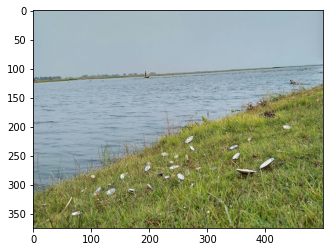

In [42]:
generate_caption("7400.jpg")

---------------------Actual---------------------
startseq দূরে অনেকগুলো গাড়ি আছে endseq
startseq অনেক গুলো ট্রাক দেখা যাচ্ছে একটি 5030.png ছেলে দাঁড়িয়ে আছে একজন গাছের নিচে বসে আছে endseq
startseq খালি জায়গা ট্রাকগুলো দাঁড়িয়ে আছে endseq
startseq খালি জায়গাটি কিছু গাছপালায় ভর্তি endseq
startseq ট্রাকে সামনে কি লোক দাঁড়িয়ে আছে endseq
--------------------Predicted--------------------
startseq একটি রাস্তা দিয়ে একজন লোক হেটে আসছে endseq


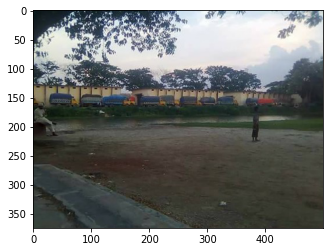

In [43]:
generate_caption("7500.jpg")

---------------------Actual---------------------
startseq একজন মানুষ হেঁটে যাচ্ছে endseq
startseq মাটির উপর একটি নৌকা আর দূরে একজন ফেরিওয়লা হেটে যাচ্ছে endseq
startseq মাটিতে একটি নৌকা আছে endseq
startseq ভাঁড় নিয়ে একজন লোক হেঁটে যাচ্ছে endseq
startseq একজন মানুষ হেঁটে যাচ্ছে দূরে অনেকগুলো গাছ আছে endseq
--------------------Predicted--------------------
startseq একজন মাঝি নৌকা চালাচ্ছে endseq


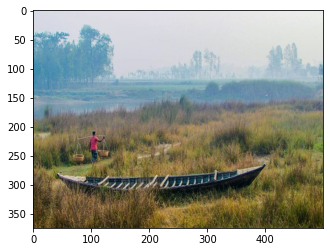

In [44]:
generate_caption("6010.jpg")

---------------------Actual---------------------
startseq নৌকাতে কয়েকজন মানুষ আছে endseq
startseq নদীতে নৌকার উপর কিছু ছেলেপেলে দাড়িয়ে কিছু বসে আর কিছু লাফ দিচ্ছে endseq
startseq একটি নৌকা থেকে দুইটি শিশু পানিতে লাফ দিচ্ছে endseq
startseq একটি শিশু নৌকাই বসে দড়ি ধরে টানছে endseq
startseq অনেকগুলো শিশু আছে endseq
--------------------Predicted--------------------
startseq মেঘলা গেঞ্জি মেঘলা গেঞ্জি পরে একজন লোক বালুর উপর দিয়ে নৌকা বাইচে endseq


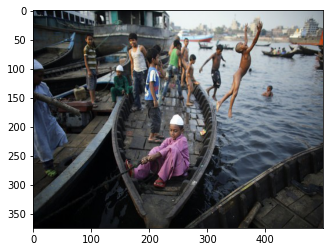

In [45]:
generate_caption("6012.jpg")

---------------------Actual---------------------
startseq একটি পাখি আছে endseq
startseq একটি শালিক উড়ছে পাশে একটি বড় গাছ endseq
startseq গাছে একটি শালিক উড়ছে endseq
startseq একটি শালিক গাছের কোটের প্রবেশ করছে endseq
startseq একটি পাখি উড়ছে endseq
--------------------Predicted--------------------
startseq একটি গাছে একটি শালিক খাচ্ছে পাশে একটি গাছে কিছু পাখি আছে endseq


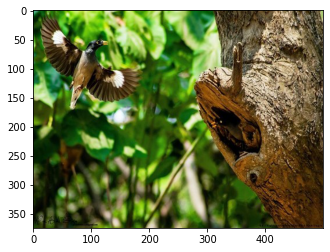

In [46]:
generate_caption("6013.jpg")

---------------------Actual---------------------
startseq পানিতে একজন বয়স্ক নারী হাঁটছে endseq
startseq একজন বৃদ্ধা পানির ভেতর দিয়ে হেটে আসছে আর পেছনে কয়েকজন মানুষ endseq
startseq একজন বয়স্ক মহিলা দাঁড়িয়ে আছে endseq
startseq হাঁটু পানিতে একজন বৃদ্ধা লাঠি ভর করে হাঁটছে endseq
startseq একজন মহিলা হাঁটছে পেছনে কয়েকজন মানুষ দাঁড়িয়ে আছে endseq
--------------------Predicted--------------------
startseq বৃষ্টির কারনে রাস্তা দিয়ে হেটে আসছে একজন বুড়ো পুরুষ মানুষ endseq


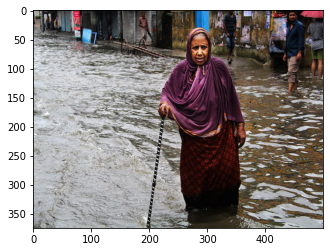

In [47]:
generate_caption("6008.jpg")